**Architecture **

<img src="http://drive.google.com/uc?export=view&id=12JomC2IswVbNGdE0IIvPpUk8vPjP-MBQ"  alt="artchtecture">


---



(1) Importing dependency

In [17]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import os

import numpy as np
np.random.seed(13)
import random
random.seed(13)

import matplotlib.pyplot as plt
% matplotlib inline

(2) Get Data

In [18]:
base_dir = '/data/private/SU/bbchip13/chainsaw_classification/data/'
chainsaw_wav_dir = base_dir+'chainsaw/'
other_wav_dir = base_dir+'no_chainsaw/'

In [19]:
chainsaw_list = [chainsaw_wav_dir+filename for filename in os.listdir(chainsaw_wav_dir) 
                 if filename.endswith('.wav')]
chainsaw_list = sklearn.utils.shuffle(chainsaw_list)
# chainsaw_list = chainsaw_list[:1200]
chainsaw_list = chainsaw_list
chainsaw_labels = np.ones(len(chainsaw_list))

no_chainsaw_list = [other_wav_dir+filename for filename in os.listdir(other_wav_dir)
                    if filename.endswith('.wav')]
no_chainsaw_list = sklearn.utils.shuffle(no_chainsaw_list)
# no_chainsaw_list = no_chainsaw_list[:1200]
no_chainsaw_list = no_chainsaw_list
no_chainsaw_labels = np.zeros(len(no_chainsaw_list))

In [20]:
def load_wavs(filenames):
    return np.asarray([librosa.load(filename)[0] for filename in tqdm(filenames)])

### If you have lack of memory, Use this
#     wav = librosa.load(filenames[0])
#     wavs = np.zeros( (len(filenames), wav.shape[0]) )
#     for i, filename in enumerate(filenames):
#         wavs[i][:] = librosa.load(filename)[:]
#     return wavs

In [21]:
x_train_chainsaw, x_test_chainsaw, y_train_chainsaw, y_test_chainsaw \
    = train_test_split(chainsaw_list, chainsaw_labels, test_size = 0.33, random_state = 7)
x_train_no_chainsaw, x_test_no_chainsaw, y_train_no_chainsaw, y_test_no_chainsaw \
    = train_test_split(no_chainsaw_list, no_chainsaw_labels, test_size = 0.33, random_state = 7)

x_train_filenames = x_train_chainsaw+x_train_no_chainsaw
y_train = np.concatenate([y_train_chainsaw, y_train_no_chainsaw])

x_test_filenames = x_test_chainsaw+x_test_no_chainsaw
y_test = np.concatenate([y_test_chainsaw, y_test_no_chainsaw])

x_train_filenames, y_train = sklearn.utils.shuffle(x_train_filenames, y_train)
x_test_filenames, y_test = sklearn.utils.shuffle(x_test_filenames, y_test)

print('Load Train Data......')
x_train = load_wavs(x_train_filenames)
print('Load Test Data......')
x_test = load_wavs(x_test_filenames)

x_train = np.reshape(x_train, (*x_train.shape, 1))
y_train = np.reshape(y_train, (*y_train.shape, 1))
x_test = np.reshape(x_test, (*x_test.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Load Train Data......



Load Test Data......



(2218, 110250, 1) (2218, 1) (1093, 110250, 1) (1093, 1)


(3) Create a sequential model

In [22]:
### Define Parametric Softplus

# alpha * log(1 + exp(beta * x))
def ParametricSoftplus(alpha=0.2, beta=5.0):
  return lambda x: alpha * keras.activations.softplus(beta * x)

In [23]:
model=Sequential()

# 1st Convolutional Layer (conv1)
model.add(Conv1D (kernel_size=121, filters=48, strides=16, padding='same',
#                   input_shape=x_train.shape[1:]))
                  input_shape=(110250, 1)))

model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(BatchNormalization())

# Pooling (pool1)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 2nd Convolutional Layer (conv2)
model.add(Conv1D (kernel_size=25, filters=128, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(BatchNormalization())

# Pooling (pool2)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 3rd Convolutional Layer (conv3)
model.add(Conv1D (kernel_size=9, filters=192, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# 4rd Convolutional Layer (conv4)
model.add(Conv1D (kernel_size=9, filters=192, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# 5rd Convolutional Layer (conv5)
model.add(Conv1D (kernel_size=9, filters=128, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# Pooling (pool5)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 1st Dense Layer (full6)
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(Dropout(0.5)) # Drop-out value is not specified in the paper

# 2nd Dense Layer (full7)
model.add(Dense(4096))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(Dropout(0.5))

# Output Layer (full8)
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 6891, 48)          5856      
_________________________________________________________________
activation_9 (Activation)    (None, 6891, 48)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6891, 48)          192       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1723, 48)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1723, 128)         153728    
_________________________________________________________________
activation_10 (Activation)   (None, 1723, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1723, 128)         512       
__________

(4) Compile 

In [24]:
adam_with_params = keras.optimizers.Adam(lr=0.0002, beta_1=0.1, beta_2=0.999, 
                                         epsilon=1e-8)
model.compile(loss='binary_crossentropy', optimizer=adam_with_params,
              metrics=['accuracy'])

(5) Train

In [25]:
model_path = 'AlexNet_based_check_point/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                               verbose=1, save_best_only=True)

In [26]:
hist = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_split=0.3, shuffle=True, callbacks = [checkpointer])

Train on 1552 samples, validate on 666 samples
Epoch 1/100
1552/1552 [==============================] - 8s 5ms/step - loss: 0.6601 - acc: 0.6405 - val_loss: 0.7874 - val_acc: 0.6096

Epoch 00001: val_loss improved from inf to 0.78736, saving model to AlexNet_based_check_point/01-0.7874.hdf5
Epoch 2/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.5713 - acc: 0.7152 - val_loss: 0.5474 - val_acc: 0.7237

Epoch 00002: val_loss improved from 0.78736 to 0.54742, saving model to AlexNet_based_check_point/02-0.5474.hdf5
Epoch 3/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.2711 - acc: 0.9008 - val_loss: 0.4567 - val_acc: 0.8363

Epoch 00003: val_loss improved from 0.54742 to 0.45670, saving model to AlexNet_based_check_point/03-0.4567.hdf5
Epoch 4/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.2147 - acc: 0.9182 - val_loss: 0.1649 - val_acc: 0.9414

Epoch 00004: val_loss improved from 0.45670 to 0.16485, saving model to Al

1552/1552 [==============================] - 6s 4ms/step - loss: 0.0816 - acc: 0.9742 - val_loss: 0.0910 - val_acc: 0.9640

Epoch 00040: val_loss did not improve from 0.08633
Epoch 41/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.0722 - acc: 0.9787 - val_loss: 0.1101 - val_acc: 0.9610

Epoch 00041: val_loss did not improve from 0.08633
Epoch 42/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.0805 - acc: 0.9704 - val_loss: 0.2858 - val_acc: 0.9084

Epoch 00042: val_loss did not improve from 0.08633
Epoch 43/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.0844 - acc: 0.9723 - val_loss: 0.0978 - val_acc: 0.9625

Epoch 00043: val_loss did not improve from 0.08633
Epoch 44/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.0780 - acc: 0.9762 - val_loss: 0.6832 - val_acc: 0.7913

Epoch 00044: val_loss did not improve from 0.08633
Epoch 45/100
1552/1552 [==============================] - 4s 3ms/step - l


Epoch 00083: val_loss did not improve from 0.08633
Epoch 84/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.0283 - acc: 0.9903 - val_loss: 0.3570 - val_acc: 0.9234

Epoch 00084: val_loss did not improve from 0.08633
Epoch 85/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.0448 - acc: 0.9832 - val_loss: 0.2980 - val_acc: 0.9174

Epoch 00085: val_loss did not improve from 0.08633
Epoch 86/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.0608 - acc: 0.9800 - val_loss: 0.1224 - val_acc: 0.9640

Epoch 00086: val_loss did not improve from 0.08633
Epoch 87/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.0300 - acc: 0.9923 - val_loss: 1.1682 - val_acc: 0.6667

Epoch 00087: val_loss did not improve from 0.08633
Epoch 88/100
1552/1552 [==============================] - 4s 3ms/step - loss: 0.0459 - acc: 0.9845 - val_loss: 0.3174 - val_acc: 0.8979

Epoch 00088: val_loss did not improve from 0.08633
Epoch 89

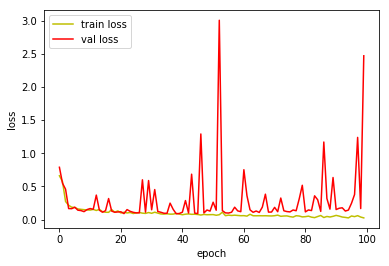

In [27]:
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

(6) Test

In [28]:
model = load_model(model_path+'39-0.0863.hdf5',custom_objects={'<lambda>': ParametricSoftplus(0.2, 0.5)})

In [29]:
[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)

1093/1093 [==============================] - 1s 1ms/step
Loss: 0.12353629554125113 Accuracy: 0.9560841720036597


In [30]:
pred = model.predict(x_test)
test_f1_score = f1_score(y_test, pred > 0.5)
print('F1 Score:', test_f1_score)

F1 Score: 0.9663865546218486


In [31]:
%timeit -n 5 -r 5 model.predict(x_test)

801 ms ± 14.5 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
